# IRC User Classifier

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph

In [50]:
import os 

project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/'
# project_dir = '/home/prenek/IRC-Behavioral-Analysis/'
log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')


data = pd.read_csv(os.path.join(out_dir, 'irc_user_features_all.csv'))
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()
# # Prepare data for training
# # Divide the data into attributes and labels
X = data.iloc[:, 2:-1]
y = data.iloc[:, 0]

X['lang'] = X['lang'].astype('category').cat.codes
X = X.apply(lambda x: x.fillna(x.mean()),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.head()

,lang,msg_lev_dist_mean,msg_lev_dist_std,msg_periodicity,msg_frequency,username_spec_chars,msg_spec_chars_mean,word_entropy,active_channels,nick_changes_count,network_info-num_services,network_info-num_users
445,20,65.150470,56.163804,1.000000,4208.331773,0.263158,0.000000,1.584963,1,1,2,30316
200,20,66.756231,36.432115,0.036756,0.000218,0.157895,0.116137,6.516522,3,1,2,30316
578,7,54.806172,26.648732,0.133975,0.007400,0.371429,0.078778,6.258380,1,1,2,30316
293,5,41.713334,23.035667,1.000000,0.000082,0.538462,0.185185,2.334256,2,1,2,30316
159,7,53.000000,23.506838,0.025795,0.014657,0.375000,0.038971,8.118007,1,1,2,30316


In [51]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X = sc.transform(X)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [56]:
import random
def pick_color(n=1):
    colors = ["blue","black","brown","red","yellow","green","orange","beige","turquoise","pink"]
    random.shuffle(colors)
    return colors[:n]

## PCA

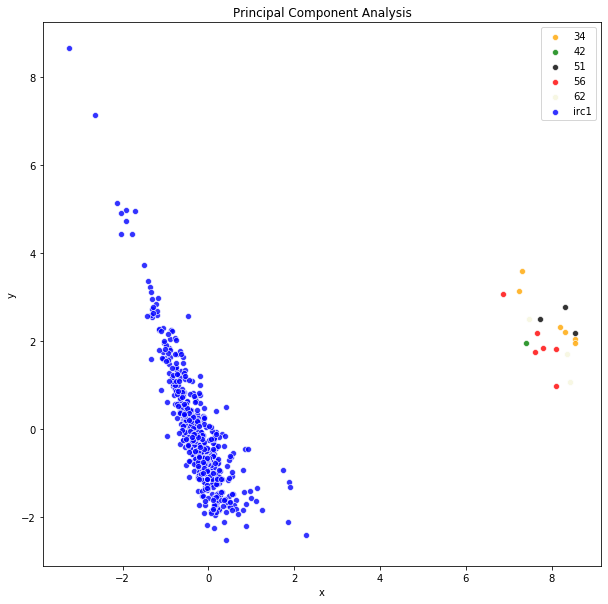

In [57]:
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)
lw = 2
# increase fig size when the point annotation is enabled
plt.figure(figsize=(10,10))
plt.title('Principal Component Analysis')
group_offset = 0
for color, i, target_name in zip(pick_color(n=len(data.pcap.unique())), data.pcap.unique(), data.pcap.unique()):
    _pca_data_x = X_pca[y == i, 0]
    _pca_data_y = X_pca[y == i, 1]
    _pca_df = pd.DataFrame({
        'x': _pca_data_x,
        'y': _pca_data_y,
        'group': list(range(group_offset, _pca_data_x.shape[0]+group_offset))
    })
    group_offset += _pca_data_x.shape[0]
    
    p1 = sns.scatterplot(x='x',y='y',data=_pca_df, color=color, alpha=.8,
                label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

## T-SNE

In [8]:
# 2D
print('t-SNE 2D...')
X_tsne_2d = TSNE(n_components=2,verbose=0).fit_transform(X)
# 3D
print('t-SNE 3D...')
X_tsne_3d = TSNE(n_components=3,verbose=0).fit_transform(X)
print('Done.')

t-SNE 2D...
t-SNE 3D...
Done.


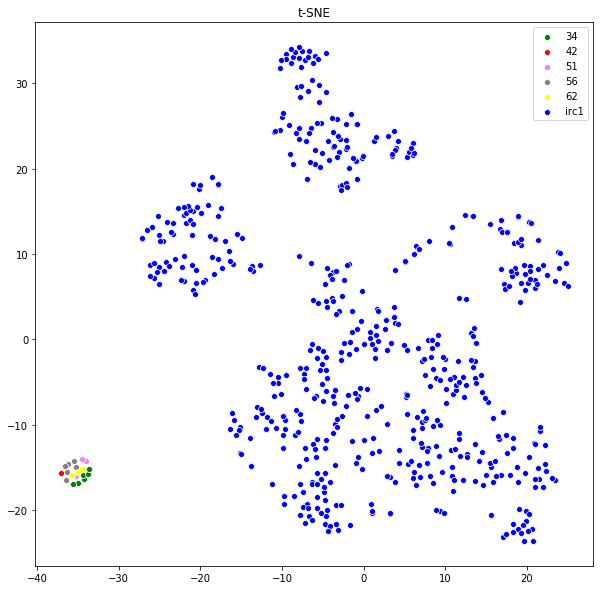

In [9]:
df_tsne_2d = pd.DataFrame({
    'x': X_tsne_2d[:,0],
    'y':X_tsne_2d[:,1],
    'label': y,
    'group': list(range(X_tsne_2d.shape[0]))
})



df_arr = []

for l in data.pcap.unique():
    df_arr.append(df_tsne_2d.where(df_tsne_2d.label==l))

plt.figure(figsize=(10,10))
plt.title('t-SNE')

for df, l, c in zip(df_arr,data.pcap.unique(), ["green","red", "violet","gray","yellow","blue"]):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

plt.xlabel('')
plt.ylabel('')
plt.show()

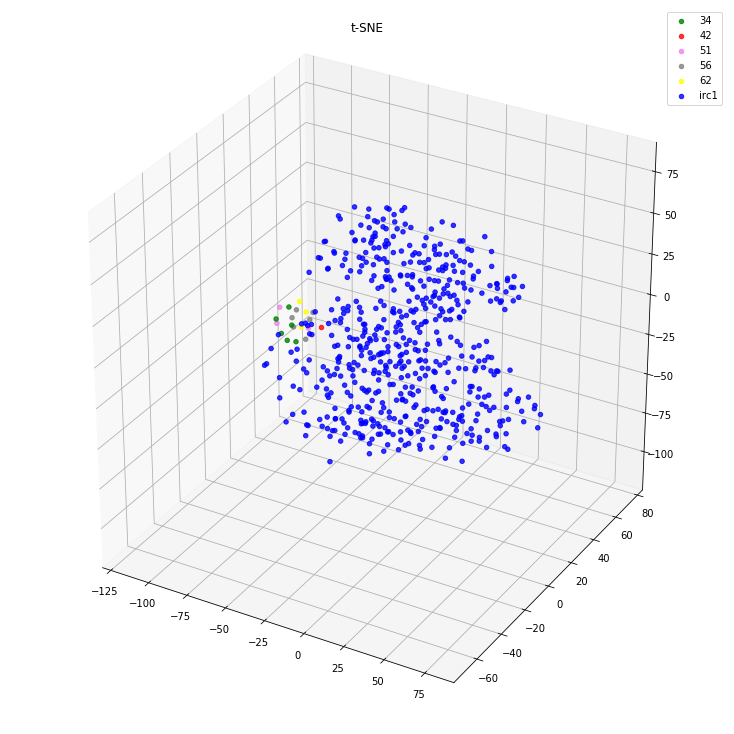

In [11]:
df_tsne_3d = pd.DataFrame({
    'x': X_tsne_3d[:,0],
    'y': X_tsne_3d[:,1],
    'z': X_tsne_3d[:,2],
    'label': y,
    'group': list(range(X_tsne_3d.shape[0]))
})

df_arr = []
for l in data.pcap.unique():
    df_arr.append(df_tsne_3d.where(df_tsne_3d.label==l))

fig = plt.figure(figsize=(10,10))
fig.suptitle('t-SNE')

ax = Axes3D(fig)

for df, l, c in zip(df_arr,data.pcap.unique(), ["green","red", "violet","gray","yellow","blue"]):
    ax.scatter(df.x, df.y, df.z, c=c, marker='o', alpha=0.8, label=l)

ax.legend()
plt.show()

In [12]:
y = y.astype('category').cat.codes
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

## UMAP

In [13]:
umap_emb = umap.UMAP(n_neighbors=5).fit_transform(X,y=y)

df_umap = pd.DataFrame({
    'x': umap_emb[:,0],
    'y': umap_emb[:,1],
    'label': y,
    'group': list(range(umap_emb.shape[0]))
})

df_arr = []
for l in y.unique():
    df_arr.append(df_umap.where(df_umap.label==l))

/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


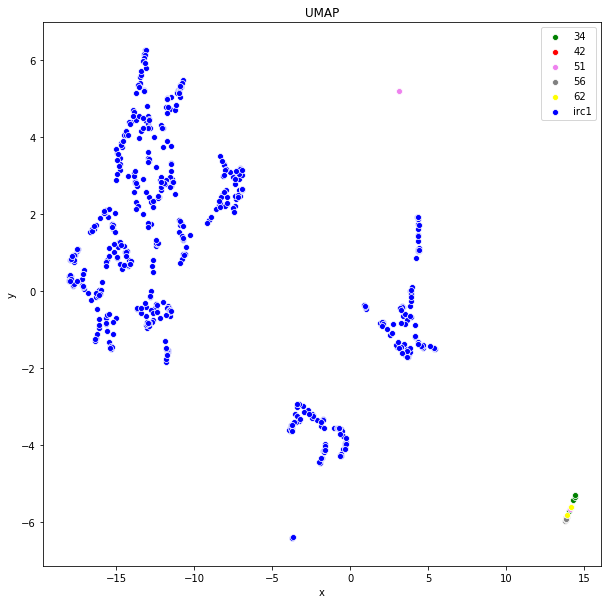

In [14]:
plt.figure(figsize=(10,10))
plt.title('UMAP')

for df, l, c in zip(df_arr, data.pcap.unique(), ["green","red", "violet","gray","yellow","blue"]):
    sns.scatterplot(
        x='x',y='y',
        color=c,
        data=df,
        label=l,
        alpha=1)

## Unsupervised Learning

### K-Means

In [15]:
kmeans = KMeans(n_clusters=len(y_train.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(X_train, y_train.values)
y_pred_kmeans = kmeans.predict(X_test)

print('K-Means accuracy:\t{}%'.format(round(accuracy_score(y_test.values, y_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test.values, y_pred_kmeans, average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test.values, y_pred_kmeans, average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test.values, y_pred_kmeans, average='micro')*1e02,2)))

K-Means accuracy:	1.14%
	precision:	1.14%
	recall:		1.14%
	f1-score:	1.14%


#### K-Means - PCA embedded space

In [16]:
kmeans = KMeans(n_clusters=len(y_train.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(X_pca, y_train.values)
y_pred_kmeans = kmeans.predict(X_pca)

print('K-Means-PCA: accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y, y_pred_kmeans, average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y, y_pred_kmeans, average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y, y_pred_kmeans, average='micro')*1e02,2)))

K-Means-PCA: accuracy:	11.17%
	precision:	11.17%
	recall:		11.17%
	f1-score:	11.17%


#### K-Means - t-SNE 2D embedded space

In [17]:
kmeans = KMeans(n_clusters=len(y.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(np.column_stack([df_tsne_2d['x'], df_tsne_2d['y']]), df_tsne_2d['label'])
y_tsne_2d_pred_kmeans = kmeans.predict(np.column_stack([df_tsne_2d['x'],df_tsne_2d['y']]))

print('K-Means-tsne 2D: accuracy:\t{}%'.format(round(accuracy_score(y, y_tsne_2d_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_tsne_2d_pred_kmeans,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_tsne_2d_pred_kmeans,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_tsne_2d_pred_kmeans,average='micro')*1e02,2)))

K-Means-tsne 2D: accuracy:	0.0%
	precision:	0.0%
	recall:		0.0%
	f1-score:	0.0%


#### K-Means - t-SNE 3D embedded space

In [18]:
kmeans = KMeans(n_clusters=len(y.unique()), init='k-means++', n_init=50,random_state=0 , tol=1.0e-9, verbose=0)
kmeans.fit(np.column_stack([df_tsne_3d['x'], df_tsne_3d['y'],df_tsne_3d['z']]), df_tsne_2d['label'])
y_tsne_3d_pred_kmeans = kmeans.predict(np.column_stack([df_tsne_3d['x'],df_tsne_3d['y'], df_tsne_3d['z']]))

print('K-Means 2D accuracy:\t{}%'.format(round(accuracy_score(y, y_tsne_3d_pred_kmeans)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_tsne_3d_pred_kmeans,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_tsne_3d_pred_kmeans,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_tsne_3d_pred_kmeans,average='micro')*1e02,2)))

K-Means 2D accuracy:	18.21%
	precision:	18.21%
	recall:		18.21%
	f1-score:	18.21%


### K-NN

In [19]:
from irc_utils import compute_score
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X,y)
y_pred_knn = knn.predict(X)

print('K-NN accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn,average='micro')*1e02,2)))

K-NN accuracy:	99.31%
	precision:	99.31%
	recall:		99.31%
	f1-score:	99.31%


#### K-NN on PCA embedded space

In [20]:
knn_tsne2d = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn_tsne2d.fit(X_pca,y)

y_pred_knn_tsne2d = knn_tsne2d.predict(X_pca)

print('K-NN accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_tsne2d)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))

K-NN accuracy:	98.63%
	precision:	98.63%
	recall:		98.63%
	f1-score:	98.63%


#### K-NN on t-SNE 2D-embedded space

In [21]:
knn_tsne2d = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn_tsne2d.fit(np.column_stack([df_tsne_2d['x'],df_tsne_2d['y']]),y)

y_pred_knn_tsne2d = knn_tsne2d.predict(np.column_stack([df_tsne_2d['x'],df_tsne_2d['y']]))

print('K-NN accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_tsne2d)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))

K-NN accuracy:	99.31%
	precision:	99.31%
	recall:		99.31%
	f1-score:	99.31%


#### K-NN on t-SNE 3D-embedded space

In [22]:
knn_tsne3d = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn_tsne3d.fit(np.column_stack([df_tsne_3d['x'],df_tsne_3d['y'], df_tsne_3d['z']]), y)

y_pred_knn_tsne2d = knn_tsne3d.predict(np.column_stack([df_tsne_3d['x'],df_tsne_3d['y'],df_tsne_3d['z']]))

print('K-NN accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_tsne2d)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_tsne2d,average='micro')*1e02,2)))

K-NN accuracy:	98.97%
	precision:	98.97%
	recall:		98.97%
	f1-score:	98.97%


### Hierarchical Clustering

In [23]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=len(y.unique()), affinity='euclidean', linkage='ward')

y_pred_knn_cluster = cluster.fit_predict(X)

print('AgglomerativeClustering accuracy:\t{}%'.format(round(accuracy_score(y, y_pred_knn_cluster)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred_knn_cluster,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred_knn_cluster,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred_knn_cluster,average='micro')*1e02,2)))

AgglomerativeClustering accuracy:	14.43%
	precision:	14.43%
	recall:		14.43%
	f1-score:	14.43%


# Supervised Learning

## Linear Regression

In [24]:
from sklearn.linear_model import SGDClassifier
# C, kernel, gamma = clf.best_params_['C'], clf.best_params_['kernel'], clf.best_params_['gamma']
linreg = SGDClassifier()

linreg.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
y_pred = linreg.predict(X_test)

print('Linear Regression accuracy:\t{}%'.format(round(accuracy_score(y_test, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y_test,y_pred,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y_test,y_pred,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y_test,y_pred,average='micro')*1e02,2)))

Linear Regression accuracy:	1.14%
	precision:	1.14%
	recall:		1.14%
	f1-score:	1.14%


## Logistic Regression

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20)
    }
]

# Create grid search object
pipe = Pipeline([('classifier' , LogisticRegression())])
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X, y)
logreg_model = best_clf.best_params_['classifier']

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.4s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/py

In [27]:
best_clf.best_params_

{'classifier': LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 'classifier__C': 4.281332398719396,
 'classifier__penalty': 'l1'}

In [28]:
y_pred = logreg_model.predict(X)

print('Logistic Regression accuracy:\t{}%'.format(round(accuracy_score(y, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred,average='micro')*1e02,2)))

Logistic Regression accuracy:	99.83%
	precision:	99.83%
	recall:		99.83%
	f1-score:	99.83%


In [29]:
train_ratio = np.arange(0.5,1,0.01)
n_samples = len(X)
train_size = list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, random_state=0)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tmp, y_tmp, train_size=0.8, random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train2, y_train2)
    
    y_pred_trn = logreg.predict(X_train2)
    y_pred_tst = logreg.predict(X_test2)
    
    score_trn = f1_score(y_train2, y_pred_trn, average='micro')
    score_tst = f1_score(y_test2, y_pred_tst, average='micro')
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)

print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0)
score_tst_list = np.stack(score_tst_list, axis=0)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

shape: 50,0.9870689655172413


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

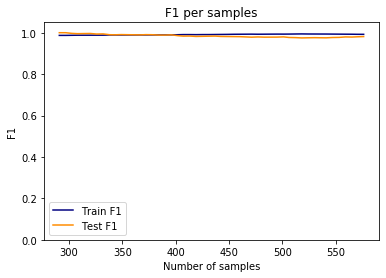

In [30]:
from irc_utils import exponential_moving_average
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0,1.05)
plt.show()

## SVM

In [31]:
from sklearn.svm import SVC

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]


#     print("# Tuning hyper-parameters for %s" % score)
#     print()

clf = GridSearchCV(SVC(C=1), tuned_parameters,cv=3)
clf.fit(X, y)

clf.best_params_

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


{'C': 50, 'gamma': 0.01, 'kernel': 'sigmoid'}

In [32]:
C, kernel, gamma = clf.best_params_['C'], clf.best_params_['kernel'], clf.best_params_['gamma']
my_svm = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, verbose=True)
my_svm.fit(X, y)

[LibSVM]

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [33]:
y_pred = my_svm.predict(X)

print('SVM accuracy:\t{}%'.format(round(accuracy_score(y, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred,average='micro')*1e02,2)))

SVM accuracy:	99.48%
	precision:	99.48%
	recall:		99.48%
	f1-score:	99.48%


In [34]:
train_ratio = np.arange(0.5,1,0.01)
n_samples = len(X)
train_size = list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, random_state=0)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tmp, y_tmp, train_size=0.8, random_state=0)
    svc = SVC()
    svc.fit(X_train2, y_train2)
    
    y_pred_trn = svc.predict(X_train2)
    y_pred_tst = svc.predict(X_test2)
    
    score_trn = f1_score(y_train2, y_pred_trn, average='micro')
    score_tst = f1_score(y_test2, y_pred_tst, average='micro')
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)

print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0)
score_tst_list = np.stack(score_tst_list, axis=0)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

shape: 50,0.9870689655172413


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

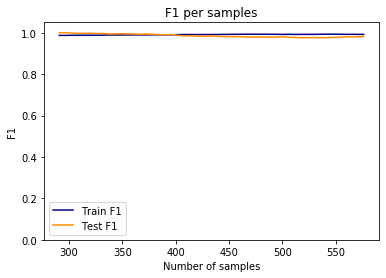

In [35]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0,1.05)
plt.show()

## Random Forrest

In [36]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
param_range = range(1,10)
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = X, y = y, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


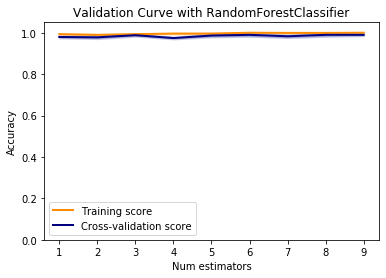

In [37]:
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel('Num estimators')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Exhaustive Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

n_estimators = [1,5,10,15, 20]
max_depth = [1,2,3,4,5,10]
min_samples_split = [2,3,4,5,10,15,20]
min_samples_leaf = [1,2,3,4,5,10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, n_jobs=-1)
bestF = gridF.fit(X_train, y_train)
print('''Best parameters: \n
- max_depth: {} \n
- min_samples_leaf: {} \n
- min_samples_split: {} \n
- n_estimators: {}'''.format(bestF.best_params_['max_depth'],
                             bestF.best_params_['min_samples_leaf'],
                             bestF.best_params_['min_samples_split'],
                             bestF.best_params_['n_estimators']))

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   50.2s


Best parameters: 

- max_depth: 4 

- min_samples_leaf: 1 

- min_samples_split: 2 

- n_estimators: 15


[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:   53.5s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [39]:
max_depth = bestF.best_params_['max_depth']
min_samples_leaf = bestF.best_params_['min_samples_leaf']
min_samples_split = bestF.best_params_['min_samples_split']
n_estimators = bestF.best_params_['n_estimators']

model = RandomForestClassifier(max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators)
model.fit(X, y)
y_pred = model.predict(X)

In [40]:
print('Random Forrest accuracy:\t{}%'.format(round(accuracy_score(y, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred,average='micro')*1e02,2)))

Random Forrest accuracy:	100.0%
	precision:	100.0%
	recall:		100.0%
	f1-score:	100.0%


In [41]:
train_ratio = np.arange(0.5,1,0.01)
n_samples = len(X)
train_size = list(map(lambda x: round(x*n_samples), train_ratio))

score_trn_list = []
score_tst_list = []
for trn_ratio in train_ratio:
    X_tmp, _, y_tmp, _ = train_test_split(X, y, train_size=trn_ratio, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size=0.7, random_state=0)
    model = RandomForestClassifier(max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators)
    model.fit(X_train, y_train)
    y_pred_trn = model.predict(X_train)
    y_pred_tst = model.predict(X_test)

    score_trn = f1_score(y_train, y_pred_trn, average='micro')
    score_tst = f1_score(y_test, y_pred_tst, average='micro')
    score_trn_list.append(score_trn)
    score_tst_list.append(score_tst)
    
print('shape: {},{}'.format(len(score_trn_list), score_trn_list[0]))
score_trn_list = np.stack(score_trn_list, axis=0 )
score_tst_list = np.stack(score_tst_list, axis=0 )

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarn

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarn

shape: 50,1.0


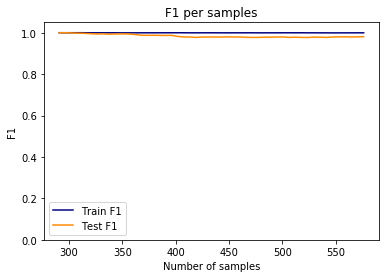

In [42]:
trn_score_f1 = exponential_moving_average(score_trn_list, 0.1)
tst_score_f1 = exponential_moving_average(score_tst_list, 0.1)

plt.title("F1 per samples")
plt.xlabel('Number of samples')
plt.ylabel('F1')
plt.plot(train_size, trn_score_f1, label='Train F1',color='navy')
plt.plot(train_size, tst_score_f1, label='Test F1',color="darkorange")
plt.legend(loc="best")
plt.ylim(0, 1.05)
plt.show()

# XGBoost 

#### Validation curve

In [43]:
import xgboost as xgb
from sklearn.model_selection import validation_curve
param_range = range(1,10)
train_scores, test_scores = validation_curve(
                                xgb.XGBClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


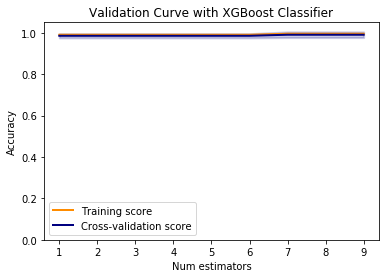

In [44]:
plt.title("Validation Curve with XGBoost Classifier")
plt.xlabel('Num estimators')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#### Exhaustive Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV

parameters =    {
            'max_depth': [2, 3, 4, 5],
            'n_estimators': [5, 10, 25],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'colsample_bytree': [0.6, 0.8, 1],
            'reg_alpha': [1e-2, 1e-1, 1e1,10],
            'reg_lambda': [1e-2, 1e-1, 1e1,10],
            }

clf = GridSearchCV(xgb.XGBClassifier(), parameters, scoring = 'accuracy', cv = 3, verbose = 1, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 8988 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 15552 out of 15552 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5], 'n_estimators': [5, 10, 25], 'gamma': [0, 0.1, 0.2], 'min_child_weight': [0, 0.5, 1], 'colsample_bytree': [0.6, 0.8, 1], 'reg_alpha': [0.01, 0.1, 10.0, 10], 'reg_lambda': [0.01, 0.1, 10.0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [58]:
clf.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'max_depth': 2,
 'min_child_weight': 0,
 'n_estimators': 5,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01}

In [ ]:
p = clf.best_params_

In [47]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=0, max_depth=2,
 min_child_weight=0, n_estimators=10, reg_alpha=0.01,reg_lambda=0.01)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=0, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [48]:
y_pred = xgb_model.predict(X)

print('XGBoost accuracy:\t{}%'.format(round(accuracy_score(y, y_pred)*1e02,2)))
print('\tprecision:\t{}%'.format(round(precision_score(y,y_pred,average='micro')*1e02,2)))
print('\trecall:\t\t{}%'.format(round(recall_score(y,y_pred,average='micro')*1e02,2)))
print('\tf1-score:\t{}%'.format(round(f1_score(y,y_pred,average='micro')*1e02,2)))

XGBoost accuracy:	99.48%
	precision:	99.48%
	recall:		99.48%
	f1-score:	99.48%
